In [60]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import auc, roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [61]:
# Load partitions path: /media/william/NVME/projects/malaria-pibiti/1_entrada/partitions
path_partitions = '/media/william/NVME/projects/malaria-pibiti/1_entrada/partitions'
partitions = os.listdir(path_partitions) # 100 partitions Image,Class,Train,Test , 1.csv 2.csv 3.csv ... 100.csv
# order by partition number
partitions.sort(key=lambda x: int(x.split('.')[0]))
print(partitions)

# Path to Image in partition
path_image = '/media/william/NVME/projects/malaria-pibiti/1_entrada/'
dataset_names = [  'Dataset01_100', 'Dataset01_95.0',  'Dataset01_90.0']
""" 'Dataset01_85.0' , 'Dataset01_80.0',
                          'Dataset01_75.0',  'Dataset01_70.0',  'Dataset01_65.0',  'Dataset01_60.0',  'Dataset01_55.0',
                          'Dataset01_50.0',  'Dataset01_45.0',  'Dataset01_40.0','Dataset01_35.0',  'Dataset01_30.0',
                            'Dataset01_25.0',  'Dataset01_20.0',  'Dataset01_15.0',  'Dataset01_10.0',  'Dataset01_5.0'"""

# {'Dataset01__100': path_image+dataset_names[0]}
paths_datasets = {dataset_names[i]: path_image+dataset_names[i] for i in range(len(dataset_names))}

path_results = '/media/william/NVME/projects/malaria-pibiti/6_resultados'


['1.csv', '2.csv', '3.csv', '4.csv', '5.csv', '6.csv', '7.csv', '8.csv', '9.csv', '10.csv', '11.csv', '12.csv', '13.csv', '14.csv', '15.csv', '16.csv', '17.csv', '18.csv', '19.csv', '20.csv', '21.csv', '22.csv', '23.csv', '24.csv', '25.csv', '26.csv', '27.csv', '28.csv', '29.csv', '30.csv', '31.csv', '32.csv', '33.csv', '34.csv', '35.csv', '36.csv', '37.csv', '38.csv', '39.csv', '40.csv', '41.csv', '42.csv', '43.csv', '44.csv', '45.csv', '46.csv', '47.csv', '48.csv', '49.csv', '50.csv', '51.csv', '52.csv', '53.csv', '54.csv', '55.csv', '56.csv', '57.csv', '58.csv', '59.csv', '60.csv', '61.csv', '62.csv', '63.csv', '64.csv', '65.csv', '66.csv', '67.csv', '68.csv', '69.csv', '70.csv', '71.csv', '72.csv', '73.csv', '74.csv', '75.csv', '76.csv', '77.csv', '78.csv', '79.csv', '80.csv', '81.csv', '82.csv', '83.csv', '84.csv', '85.csv', '86.csv', '87.csv', '88.csv', '89.csv', '90.csv', '91.csv', '92.csv', '93.csv', '94.csv', '95.csv', '96.csv', '97.csv', '98.csv', '99.csv', '100.csv']


In [62]:
#Save results

def make_results_folders(path_results, dataset_name, method):
    path_dataset = os.path.join(path_results, dataset_name)
    if not os.path.exists(path_dataset):
        os.mkdir(path_dataset)
    path_method = os.path.join(path_dataset, method)
    if not os.path.exists(path_method):
        os.mkdir(path_method)
    path_metrics = os.path.join(path_method, 'metrics')
    if not os.path.exists(path_metrics):
        os.mkdir(path_metrics)
    path_csvs = os.path.join(path_method, 'csvs')
    if not os.path.exists(path_csvs):
        os.mkdir(path_csvs)
    path_test = os.path.join(path_method, 'test')
    if not os.path.exists(path_test):
        os.mkdir(path_test)
    return path_metrics, path_csvs, path_test

In [63]:
# config video 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [64]:
methodsNames = ['KNN', 'NBayes', 'RandomForest' ,'SGD' ]
input_size = (128, 128)

In [65]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import NuSVC, SVC, LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis, StandardScaler
from tune_sklearn import TuneGridSearchCV

# get dynamic cores
import multiprocessing
cores = multiprocessing.cpu_count()
# use 1/2 of the cores
cores = cores - 1

def train_ml_algorithm(X_train, y_train, methodName):

    search = None
    # KNN
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier
    if (methodName == 'KNN'): 
        standardized_data = StandardScaler()
        var_filter = VarianceThreshold()
        knn = KNeighborsClassifier()
        pipe = Pipeline([('standardized_data', standardized_data),
                        ('var_filter', var_filter),
                        ('knn', knn)])
        # parameters = {
        #     "n_neighbors" : [1, 2, 3, 4, 5],
        #     "weights": ['uniform', 'distance'],
        #     "algorithm": ['ball_tree', 'kd_tree', 'brute'],
        #     "leaf_size": [5, 15, 25, 35, 45, 55],
        #     'p': [10, 20, 40],
        #     "metric": ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
        # }
        parameters = [{'knn__n_neighbors':[1,2,3,4,5], 'knn__algorithm':['brute'], 'knn__metric':['euclidean']}]
        search  = GridSearchCV(
            estimator=pipe,
            param_grid=parameters,
            cv=ShuffleSplit(test_size=0.01, n_splits=1, random_state=0),
            scoring='accuracy',
            n_jobs=cores,
            verbose=1
        )
    
    # AdaBoost
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC
    elif (methodName == 'AdaBoost'): 
        parameters = {
            # 'base_estimator': [None],
            "n_estimators" : [100],
            'algorithm': ['SAMME'],
            'random_state': [0],
        }
        search  = GridSearchCV( 
            estimator=AdaBoostClassifier(),
            cv=ShuffleSplit(test_size=0.01, n_splits=1, random_state=0),
            scoring='accuracy',
            param_grid=parameters,
            n_jobs=-1
        )
   
    # SGD
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgd#sklearn.linear_model.SGDClassifier
    elif (methodName == 'SGD'): 
        parameters = {
            'penalty': ['l2', 'l1', 'elasticnet'],
            'alpha': [0.0001,],
            'epsilon':[0.01, 0.1, 1],
            'l1_ratio': [0.10, 0.15, 0.2, 0.25],
            'fit_intercept': [True, False],
            'max_iter': [1000, 1200],
            'shuffle': [True, False],
            'early_stopping': [True],
            'n_iter_no_change': [3],
        }
        lr = SGDClassifier()
        search  = TuneGridSearchCV( 
            estimator=lr,
            param_grid=parameters,
            cv=ShuffleSplit(test_size=0.01, n_splits=1, random_state=0),
            scoring='accuracy',
            n_jobs=cores
        )

    # Naive Bayes
    # https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB
    elif (methodName == 'NBayes'): 
        parameters = {
            # 'priors': None,
            "var_smoothing" : np.logspace(0,-9, num=100),
        }
        search  = GridSearchCV( 
            estimator=GaussianNB(),
            param_grid=parameters,
            cv=ShuffleSplit(test_size=0.01, n_splits=1, random_state=0),
            scoring='accuracy',
            n_jobs=cores
        )

    # RandomForest
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random#sklearn.ensemble.RandomForestClassifier
    elif (methodName == 'RandomForest'): 
        parameters = {
            "n_estimators" : [10, 100, 1000],
            'criterion': ["entropy"],
            'max_depth': [None],
            "max_features" : ['sqrt', 'log2'],
            'verbose': [0],
            'class_weight': ['balanced','balanced_subsample'],
        }
        search  = GridSearchCV( 
            estimator=RandomForestClassifier(),
            param_grid=parameters,
            cv=ShuffleSplit(test_size=0.01, n_splits=1, random_state=0),
            scoring='accuracy',
            n_jobs=cores
        )
    else:
        results = None
    
    
    if (search != None):
        results = search.fit(X_train, y_train)

    return results
    

In [66]:
# configure colors
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


In [67]:

# Configure personal metrics
def specificity(tn, fp):
    return tn / (tn + fp)

# Negative Predictive Error
def npv(tn, fn):
    return tn / (tn + fn + 1e-7)

# Matthews Correlation_Coefficient
def mcc(tp, tn, fp, fn):
    num = tp * tn - fp * fn
    den = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    return num / np.sqrt(den + 1e-7)


def calculateMeasures(dataset, Y_pred, Y_true, Yscores, y_pred, y_true, yscores, folder, methodName, thresh, save_metrics_path, runtimeTrain, runtimeTest):
    metrics = pd.DataFrame()
    tn, fp, fn, tp = confusion_matrix(Y_true, Y_pred, labels=[0,1]).ravel()
    #fpr, tpr, _ = roc_curve(y_true, scores, pos_label=2)
    auc_val = roc_auc_score(Y_true, Yscores)

    metrics['dataset'] = [dataset]
    metrics['network'] = [methodName]
    metrics['partition'] = [folder]

    

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    #fpr, tpr, _ = roc_curve(y_true, scores, pos_label=2)
    auc_val = roc_auc_score(y_true, yscores)

    # Train RESULTS
    metrics['accuracy'] = [accuracy_score(Y_true, Y_pred)]
    metrics['precision'] = [precision_score(Y_true, Y_pred)]
    metrics['sensitivity'] = [recall_score(Y_true, Y_pred)]
    metrics['specificity'] = [specificity(tn,fp)]
    metrics['f1_score'] = [f1_score(Y_true, Y_pred)]
    metrics['npv'] = [npv(tn, fn)]
    metrics['mcc'] = [mcc(tp, tn, fp, fn)]
    metrics['auc'] = [auc_val]
    metrics['TP'] = [tp]
    metrics['TN'] = [tn]
    metrics['FP'] = [fp]
    metrics['FN'] = [fn]
    metrics['runtime'] = [runtimeTrain]

    # Test RESULTS
    metrics['val_accuracy'] = [accuracy_score(y_true, y_pred)]
    metrics['val_precision'] = [precision_score(y_true, y_pred)]
    metrics['val_sensitivity'] = [recall_score(y_true, y_pred)]
    metrics['val_specificity'] = [specificity(tn,fp)]
    metrics['val_f1_score'] =[f1_score(y_true, y_pred)]
    metrics['val_npv'] = [npv(tn, fn)]
    metrics['val_mcc'] = [mcc(tp, tn, fp, fn)]
    metrics['val_auc'] = [auc_val]
    metrics['val_TP'] = [tp]
    metrics['val_TN'] = [tn]
    metrics['val_FP'] = [fp]
    metrics['val_FN'] = [fn]
    metrics['val_runtime'] = [runtimeTest]



    print(bcolors.FAIL + 'ACC: %.2f' %(100*metrics['val_accuracy'][0]) + ' AUC: %.2f' %(100*metrics['val_auc'][0]) + bcolors.ENDC)

    if os.path.exists(os.path.join(save_metrics_path, methodName + '.csv')):
        metrics.to_csv(os.path.join(save_metrics_path, methodName + '.csv'), sep=',', mode='a', index=False, header=False)
    else:
        metrics.to_csv(os.path.join(save_metrics_path, methodName + '.csv'), sep=',', index=False)  

In [68]:
import csv

from PIL import Image
import cv2
def load_dataset(path_partition_name: str, data_set_name: str) -> tuple:
    TrainImages, TestImages, TrainLabels, TestLabels = list(), list(), list(), list()

    # Load partition
    partition = pd.read_csv(os.path.join(path_partitions, path_partition_name))
    partition = partition.dropna()
    partition = partition.drop_duplicates()
    partition = partition.reset_index(drop=True)
    #print(partition)
    # Load images and labels
    for i in range(len(partition)):
        path_img = os.path.join(paths_datasets[data_set_name], partition['Image'][i][1:])
        #print(path_img)
        img  = select_image(path_img)
        if img is not None:
            if partition['Train'][i] == 1:
                TrainImages.append(img)
                TrainLabels.append(partition['Class'][i])
            else:
                TestImages.append(img)
                TestLabels.append(partition['Class'][i])
        
    return np.array(TrainImages)/255.0, TrainLabels, np.array(TestImages)/255.0, TestLabels

def select_image(path_img_filename):
    """
    Select and preprocess a single image.
    """
    try:
        image = cv2.imread(path_img_filename, cv2.IMREAD_GRAYSCALE)
        image_array = Image.fromarray(image)
        return np.array(image_array)
    except IOError:
        print(f"Error opening {path_img_filename}.")
        return None
    
def flatten_images(cells):
    #flatten the 128x128x3 or 128x128 dimensions into a feature vector of 7500 or 2500 values
    cells_flattened = cells[:].reshape(cells.shape[0], cells.shape[1] * cells.shape[2])
    print(cells_flattened.shape)
    return cells_flattened

(4746, 128, 128) 4746 (1256, 128, 128) 1256


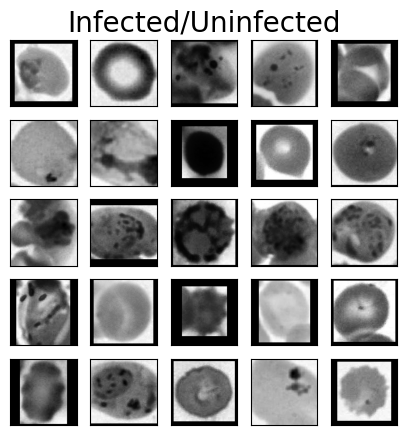

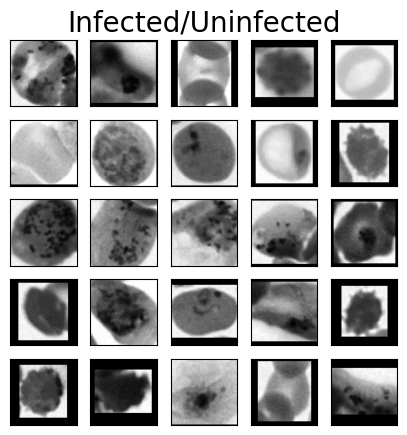

In [69]:
import matplotlib.pyplot as plt

def inspect_images(
    path_partition_name: str, data_set_name: str
):
    TrainImages, TrainLabels, TestImages, TestLabels = load_dataset(path_partition_name, data_set_name)
    print(TrainImages.shape, len(TrainLabels), TestImages.shape, len(TestLabels))
    np.random.seed(155)
    random_25 = np.random.randint(0,TrainImages.shape[0], size=25)
    fig=plt.figure(figsize=(5,5))
    plt.title("Infected/Uninfected",fontsize=20)
    plt.axis('off')
    for ind,rand in enumerate(random_25):
        ax_n=fig.add_subplot(5,5,ind+1)
        ax_n.imshow(TrainImages[rand],cmap=plt.cm.gray)
        ax_n.get_xaxis().set_visible(False)
        ax_n.get_yaxis().set_visible(False)
    plt.show()

    np.random.seed(155)
    random_25 = np.random.randint(0,TestImages.shape[0], size=25)
    fig=plt.figure(figsize=(5,5))
    plt.title("Infected/Uninfected",fontsize=20)
    plt.axis('off')
    for ind,rand in enumerate(random_25):
        ax_n=fig.add_subplot(5,5,ind+1)
        ax_n.imshow(TestImages[rand],cmap=plt.cm.gray)
        ax_n.get_xaxis().set_visible(False)
        ax_n.get_yaxis().set_visible(False)
    plt.show()

 
inspect_images(partitions[0], dataset_names[0])

In [70]:
import gc
import time

def process_in_batches(X, y, batch_size):
    """Yield successive n-sized chunks from X and y."""
    for i in range(0, len(X), batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

def adjust_scores(Yscores_batch, Y_pred_batch):
    """Adjust scores if only one column is present."""
    if Yscores_batch.shape[1] == 1:
        if np.all(Y_pred_batch == 0):
            Yscores_batch = np.hstack([Yscores_batch, 1 - Yscores_batch])
        else:
            Yscores_batch = np.hstack([1 - Yscores_batch, Yscores_batch])
    return Yscores_batch[:, 1]

def process_partition(network, dataset_name, partition, batch_size):
    """Process training and testing for a single partition."""
    path_metrics, path_csvs, path_test = make_results_folders(path_results, dataset_name, network)
    X_train, y_train, X_test, y_test = load_dataset(partition, dataset_name)
    if X_train is None:
        return

    X_train, X_test = map(flatten_images, (X_train, X_test))

    # Initialize and process in batches
    all_Y_pred, all_Yscores, all_y_pred, all_yscores = [], [], [], []
    start_time = time.time()

    # Training
    for X_batch, y_batch in process_in_batches(X_train, y_train, batch_size):
        model = train_ml_algorithm(X_batch, y_batch, network)
        print_progress(all_Y_pred, X_train, "Training")

        Y_pred_batch, Yscores_batch = model.predict(X_batch), model.predict_proba(X_batch)
        Yscores_batch = adjust_scores(Yscores_batch, Y_pred_batch)
        all_Y_pred.extend(Y_pred_batch), all_Yscores.extend(Yscores_batch)

    runtime_train = time.time() - start_time

    # Testing
    for X_batch, y_batch in process_in_batches(X_test, y_test, batch_size):
        print_progress(all_y_pred, X_test, "Testing")

        y_pred_batch, yscores_batch = model.predict(X_batch), model.predict_proba(X_batch)[:, 1]
        all_y_pred.extend(y_pred_batch), all_yscores.extend(yscores_batch)
    runtime_test = time.time() - start_time

    # Metrics calculation and cleanup
    finalize_metrics(dataset_name, partition, network, all_Y_pred, y_train, all_Yscores, all_y_pred, y_test, all_yscores, runtime_train, runtime_test, path_metrics)

def print_progress(processed_items, items, phase):
    """Print progress of training/testing."""
    print(f"{100 * len(processed_items) / len(items):.2f}% completed during {phase}.")

def finalize_metrics(dataset_name, partition, network, all_Y_pred, y_train, all_Yscores, all_y_pred, y_test, all_yscores, runtime_train, runtime_test, path_metrics):

    """Final operations after processing all batches."""
    dataset_number = dataset_name.split('_')[1].split('.')[0]
    calculateMeasures(dataset_number, all_Y_pred, y_train, all_Yscores, all_y_pred, y_test, all_yscores, partition.split('.')[0], network, 0.2, path_metrics, runtime_train, runtime_test)
    print(f"Finished processing {network} on {partition} with dataset {dataset_name}. Calculating metrics...")
    gc.collect()

def main():
    """Main function to process all partitions and networks."""
    for network in methodsNames:
        for dataset_name in dataset_names:
            for partition in partitions:
                print(f"Processing {network} on {partition} with dataset {dataset_name}.")
                process_partition(network, dataset_name, partition, 8)

main()

Processing NBayes on 1.csv with dataset Dataset01_100.
(4746, 16384)
(1256, 16384)
0.00% completed during Training.
0.17% completed during Training.
0.34% completed during Training.
0.51% completed during Training.
0.67% completed during Training.
0.84% completed during Training.
1.01% completed during Training.
1.18% completed during Training.
1.35% completed during Training.
1.52% completed during Training.
1.69% completed during Training.
1.85% completed during Training.
2.02% completed during Training.
2.19% completed during Training.
2.36% completed during Training.
2.53% completed during Training.
2.70% completed during Training.
2.87% completed during Training.
3.03% completed during Training.
3.20% completed during Training.
3.37% completed during Training.
3.54% completed during Training.
3.71% completed during Training.
3.88% completed during Training.
4.05% completed during Training.
4.21% completed during Training.
4.38% completed during Training.
4.55% completed during Tra

/home/william/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/william/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/william/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:510: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/home/william/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/home/william/.local/lib/python3.10/site-packages/sklearn/naive_bayes.py:511: RuntimeWarning: divide by zero encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]

34.39% completed during Testing.
35.03% completed during Testing.
35.67% completed during Testing.
36.31% completed during Testing.
36.94% completed during Testing.
37.58% completed during Testing.
38.22% completed during Testing.
38.85% completed during Testing.
39.49% completed during Testing.
40.13% completed during Testing.
40.76% completed during Testing.
41.40% completed during Testing.
42.04% completed during Testing.
42.68% completed during Testing.
43.31% completed during Testing.
43.95% completed during Testing.
44.59% completed during Testing.
45.22% completed during Testing.
45.86% completed during Testing.
46.50% completed during Testing.
47.13% completed during Testing.
47.77% completed during Testing.
48.41% completed during Testing.
49.04% completed during Testing.
49.68% completed during Testing.
50.32% completed during Testing.
50.96% completed during Testing.
51.59% completed during Testing.
52.23% completed during Testing.
52.87% completed during Testing.
53.50% com

KeyboardInterrupt: 